In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 1: CLEANING SETUP                                ║
# ║              Import libraries and define cleaning functions                  ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

import pandas as pd
import numpy as np
import json
import re
from collections import Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("DATA CLEANING PIPELINE FOR MODEL TRAINING")
print("=" * 80)
print(f"⏰ Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Define cleaning functions
def remove_placeholders(text):
    """Remove placeholder text patterns"""
    if not isinstance(text, str):
        return ""
    # Remove [...] patterns
    text = re.sub(r'\[.*?\]', '', text)
    # Remove excessive ellipsis
    text = re.sub(r'\.{2,}', '', text)
    # Clean up extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def is_valid_text(text, min_length=10, max_length=500):
    """Check if text is valid for training"""
    if not isinstance(text, str):
        return False
    text = text.strip()
    # Check length
    if len(text) < min_length or len(text) > max_length:
        return False
    # Check if it's just placeholders
    if text.count('[') > 2 or text.count(']') > 2:
        return False
    # Check for excessive repetition
    words = text.split()
    if len(words) > 0:
        unique_ratio = len(set(words)) / len(words)
        if unique_ratio < 0.3:  # Too repetitive
            return False
    return True

def calculate_text_diversity(text):
    """Calculate Type-Token Ratio for a single text"""
    words = text.lower().split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

print("✅ Cleaning functions defined")

DATA CLEANING PIPELINE FOR MODEL TRAINING
⏰ Started at: 2026-02-06 13:46:45
✅ Cleaning functions defined


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_from_drive = pd.read_json('/content/drive/MyDrive/Conversational_Transcript_Dataset.json')
display(df_from_drive.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,transcripts
0,"{'transcript_id': '6794-8660-4606-3216', 'time..."
1,"{'transcript_id': '7034-5430-2980-5483', 'time..."
2,"{'transcript_id': '1846-5500-2990-8975', 'time..."
3,"{'transcript_id': '1616-8531-3291-5075', 'time..."
4,"{'transcript_id': '7441-4348-3458-2384', 'time..."


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 2: LOAD RAW DATA                                 ║
# ║              Load and display initial statistics                             ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

file_path = '/content/drive/MyDrive/Conversational_Transcript_Dataset.json'

# Load data
with open(file_path, 'r') as f:
    data = json.load(f)

transcripts = data['transcripts']
print(f"📊 Total raw transcripts: {len(transcripts)}")

# Convert to DataFrame
df_raw = pd.DataFrame(transcripts)
print(f"✅ Raw DataFrame shape: {df_raw.shape}")

# Calculate initial statistics
total_utterances_raw = sum(len(conv) for conv in df_raw['conversation'])
print(f"📝 Total raw utterances: {total_utterances_raw}")

# Display sample
print(f"\n🔍 Sample raw record:")
print(json.dumps(df_raw.iloc[0].to_dict(), indent=2)[:500] + "...")

📊 Total raw transcripts: 5037
✅ Raw DataFrame shape: (5037, 6)
📝 Total raw utterances: 84465

🔍 Sample raw record:
{
  "transcript_id": "6794-8660-4606-3216",
  "time_of_interaction": "2025-10-03 20:22:00",
  "domain": "E-commerce & Retail",
  "intent": "Delivery Investigation",
  "reason_for_call": "Customer James Bailey reported a smart watch showing as delivered but never received, requiring delivery investigation and replacement shipment.",
  "conversation": [
    {
      "speaker": "Agent",
      "text": "Hello, thank you for contacting BuyNow. This is Emma. How can I help you?"
    },
    {
      "spea...


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 3: STEP 1 - REMOVE DUPLICATES                    ║
# ║              Remove exact and near-duplicate transcripts                     ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

print("=" * 80)
print("STEP 1: DUPLICATE REMOVAL")
print("=" * 80)

initial_count = len(df_raw)
print(f"Initial records: {initial_count}")

# Check for duplicate transcript IDs
dup_ids = df_raw['transcript_id'].duplicated().sum()
print(f"Duplicate transcript IDs found: {dup_ids}")

# Remove duplicate transcript IDs (keep first)
df_no_dup_ids = df_raw.drop_duplicates(subset=['transcript_id'], keep='first')
print(f"After removing duplicate IDs: {len(df_no_dup_ids)}")

# Check for duplicate reasons (same customer issue described exactly)
dup_reasons = df_no_dup_ids['reason_for_call'].duplicated().sum()
print(f"Duplicate 'reason_for_call' entries: {dup_reasons}")

# Remove duplicate reasons
df_no_dup_reasons = df_no_dup_ids.drop_duplicates(subset=['reason_for_call'], keep='first')
print(f"After removing duplicate reasons: {len(df_no_dup_reasons)}")

# Check for duplicate conversations (exact same dialogue)
df_no_dup_reasons['conv_str'] = df_no_dup_reasons['conversation'].apply(str)
dup_convs = df_no_dup_reasons['conv_str'].duplicated().sum()
print(f"Duplicate entire conversations: {dup_convs}")

# Remove duplicate conversations
df_clean_dup = df_no_dup_reasons.drop_duplicates(subset=['conv_str'], keep='first')
df_clean_dup = df_clean_dup.drop('conv_str', axis=1)

print(f"\n✅ After Step 1 - Duplicates removed: {len(df_clean_dup)} records")
print(f"   Removed: {initial_count - len(df_clean_dup)} records ({((initial_count - len(df_clean_dup))/initial_count)*100:.1f}%)")

STEP 1: DUPLICATE REMOVAL
Initial records: 5037
Duplicate transcript IDs found: 0
After removing duplicate IDs: 5037
Duplicate 'reason_for_call' entries: 490
After removing duplicate reasons: 4547
Duplicate entire conversations: 0

✅ After Step 1 - Duplicates removed: 4547 records
   Removed: 490 records (9.7%)


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 4: STEP 2 - CLEAN CONVERSATIONS                  ║
# ║              Remove placeholder text and invalid utterances                  ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

print("=" * 80)
print("STEP 2: CONVERSATION CLEANING")
print("=" * 80)

records_after_cleaning = []
removed_stats = {
    'placeholder_utterances': 0,
    'too_short': 0,
    'too_long': 0,
    'too_repetitive': 0,
    'invalid_speaker': 0,
    'empty_after_cleaning': 0
}

for idx, row in df_clean_dup.iterrows():
    clean_conversation = []

    for turn in row['conversation']:
        speaker = turn.get('speaker', '')
        text = turn.get('text', '')

        # Skip invalid speakers
        if speaker not in ['Agent', 'Customer']:
            removed_stats['invalid_speaker'] += 1
            continue

        # Clean the text
        cleaned_text = remove_placeholders(text)

        # Check if valid
        if not is_valid_text(cleaned_text):
            if len(cleaned_text) < 10:
                removed_stats['too_short'] += 1
            elif len(cleaned_text) > 500:
                removed_stats['too_long'] += 1
            elif calculate_text_diversity(cleaned_text) < 0.3:
                removed_stats['too_repetitive'] += 1
            else:
                removed_stats['placeholder_utterances'] += 1
            continue

        # Check for remaining placeholders
        if '[' in cleaned_text or ']' in cleaned_text:
            removed_stats['placeholder_utterances'] += 1
            continue

        clean_conversation.append({
            'speaker': speaker,
            'text': cleaned_text
        })

    # Only keep records with at least 2 valid turns (1 exchange)
    if len(clean_conversation) >= 2:
        records_after_cleaning.append({
            'transcript_id': row['transcript_id'],
            'time_of_interaction': row['time_of_interaction'],
            'domain': row['domain'],
            'intent': row['intent'],
            'reason_for_call': remove_placeholders(row['reason_for_call']),
            'conversation': clean_conversation
        })
    else:
        removed_stats['empty_after_cleaning'] += 1

df_clean_conv = pd.DataFrame(records_after_cleaning)

print(f"Records after conversation cleaning: {len(df_clean_conv)}")
print(f"\nRemoval statistics:")
for key, val in removed_stats.items():
    print(f"   • {key}: {val}")

total_removed_step2 = len(df_clean_dup) - len(df_clean_conv)
print(f"\n✅ After Step 2 - Conversations cleaned: {len(df_clean_conv)} records")
print(f"   Removed: {total_removed_step2} records ({(total_removed_step2/len(df_clean_dup))*100:.1f}%)")

STEP 2: CONVERSATION CLEANING
Records after conversation cleaning: 4547

Removal statistics:
   • placeholder_utterances: 0
   • too_short: 360
   • too_long: 0
   • too_repetitive: 0
   • invalid_speaker: 0
   • empty_after_cleaning: 0

✅ After Step 2 - Conversations cleaned: 4547 records
   Removed: 0 records (0.0%)


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 5: STEP 3 - FILTER LOW QUALITY                   ║
# ║              Remove records with low diversity or quality issues             ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

print("=" * 80)
print("STEP 3: QUALITY FILTERING")
print("=" * 80)

quality_issues = {
    'low_diversity': 0,
    'too_few_turns': 0,
    'repetitive_reason': 0,
    'invalid_temporal': 0
}

records_high_quality = []

for idx, row in df_clean_conv.iterrows():
    # Check 1: Conversation must have sufficient turns
    if len(row['conversation']) < 4:  # At least 2 exchanges
        quality_issues['too_few_turns'] += 1
        continue

    # Check 2: Calculate conversation diversity
    all_text = ' '.join([turn['text'] for turn in row['conversation']])
    diversity = calculate_text_diversity(all_text)

    if diversity < 0.4:  # Minimum diversity threshold
        quality_issues['low_diversity'] += 1
        continue

    # Check 3: Reason for call must be valid
    reason = row['reason_for_call']
    if len(reason) < 20 or len(reason) > 300:
        quality_issues['repetitive_reason'] += 1
        continue

    # Check 4: Temporal validity (optional - remove if all future dates are problematic)
    # Skip this check if you want to keep all dates

    records_high_quality.append(row)

df_quality = pd.DataFrame(records_high_quality)

print(f"Records after quality filtering: {len(df_quality)}")
print(f"\nQuality filter statistics:")
for key, val in quality_issues.items():
    print(f"   • {key}: {val}")

total_removed_step3 = len(df_clean_conv) - len(df_quality)
print(f"\n✅ After Step 3 - Quality filtered: {len(df_quality)} records")
print(f"   Removed: {total_removed_step3} records ({(total_removed_step3/len(df_clean_conv))*100:.1f}%)")


STEP 3: QUALITY FILTERING
Records after quality filtering: 4547

Quality filter statistics:
   • low_diversity: 0
   • too_few_turns: 0
   • repetitive_reason: 0
   • invalid_temporal: 0

✅ After Step 3 - Quality filtered: 4547 records
   Removed: 0 records (0.0%)


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 6: STEP 4 - BALANCE DATASET                      ║
# ║              Balance domains and intents for better training                 ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

print("=" * 80)
print("STEP 4: DATASET BALANCING")
print("=" * 80)

# Analyze current distribution
print("Current domain distribution:")
domain_counts = df_quality['domain'].value_counts()
print(domain_counts)

print("\nCurrent intent distribution (top 10):")
intent_counts = df_quality['intent'].value_counts().head(10)
print(intent_counts)

# Set thresholds
MIN_SAMPLES_PER_DOMAIN = 50
MAX_SAMPLES_PER_INTENT = 200  # Cap over-represented intents

balanced_records = []

# Balance by intent (keep top intents, sample if too many)
for intent in intent_counts.index:
    intent_data = df_quality[df_quality['intent'] == intent]

    if len(intent_data) > MAX_SAMPLES_PER_INTENT:
        # Sample to max limit
        intent_data = intent_data.sample(MAX_SAMPLES_PER_INTENT, random_state=42)
        print(f"Sampled intent '{intent[:40]}...' from {intent_counts[intent]} to {MAX_SAMPLES_PER_INTENT}")

    balanced_records.extend(intent_data.to_dict('records'))

df_balanced = pd.DataFrame(balanced_records)

print(f"\n✅ After Step 4 - Balanced: {len(df_balanced)} records")
print(f"   Intents represented: {df_balanced['intent'].nunique()}")
print(f"   Domains represented: {df_balanced['domain'].nunique()}")

print("\nBalanced distribution:")
print(df_balanced['domain'].value_counts())

STEP 4: DATASET BALANCING
Current domain distribution:
domain
Banking & Finance       722
Healthcare Services     692
E-commerce & Retail     677
Telecommunications      638
Travel & Hospitality    625
Insurance               616
Technology Support      577
Name: count, dtype: int64

Current intent distribution (top 10):
intent
Escalation - Repeated Service Failures               487
Service Interruptions                                380
Escalation - Threat of Legal Action                  372
Account Access Issues                                363
Claim Denials                                        316
Delivery Investigation                               310
Fraud Alert Investigation                            255
Appointment Scheduling                               191
Multiple Issues - Order Status, Billing & Account    175
Multiple Issues - Returns & Account Inquiries        173
Name: count, dtype: int64
Sampled intent 'Escalation - Repeated Service Failures...' from 487 to 200

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 7: STEP 5 - FINAL VALIDATION                     ║
# ║              Validate all records and create clean dataset                   ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

print("=" * 80)
print("STEP 5: FINAL VALIDATION")
print("=" * 80)

final_records = []
validation_errors = []

for idx, row in df_balanced.iterrows():
    try:
        # Validate structure
        assert 'transcript_id' in row and row['transcript_id']
        assert 'domain' in row and row['domain']
        assert 'intent' in row and row['intent']
        assert 'reason_for_call' in row and row['reason_for_call']
        assert 'conversation' in row and len(row['conversation']) >= 2

        # Validate conversation turns
        for turn in row['conversation']:
            assert 'speaker' in turn and turn['speaker'] in ['Agent', 'Customer']
            assert 'text' in turn and len(turn['text']) >= 10
            assert '[' not in turn['text'] and ']' not in turn['text']

        # Validate alternating speakers
        speakers = [turn['speaker'] for turn in row['conversation']]
        # Allow some flexibility but flag major issues
        switches = sum(1 for i in range(1, len(speakers)) if speakers[i] != speakers[i-1])
        if switches < len(speakers) * 0.3:  # Less than 30% switches is suspicious
            validation_errors.append(f"Low speaker switches in {row['transcript_id']}")
            continue

        final_records.append(row.to_dict())

    except Exception as e:
        validation_errors.append(f"Validation error in {row.get('transcript_id', 'unknown')}: {str(e)}")

df_final = pd.DataFrame(final_records)

print(f"Final validated records: {len(df_final)}")
print(f"Validation errors: {len(validation_errors)}")
if validation_errors[:5]:
    print("Sample errors:")
    for err in validation_errors[:5]:
        print(f"   • {err}")

print(f"\n✅ CLEANING COMPLETE!")
print(f"   Original records: {len(df_raw)}")
print(f"   Final records: {len(df_final)}")
print(f"   Retention rate: {(len(df_final)/len(df_raw))*100:.1f}%")
print(f"   Total removed: {len(df_raw) - len(df_final)}")

STEP 5: FINAL VALIDATION
Final validated records: 1939
Validation errors: 0

✅ CLEANING COMPLETE!
   Original records: 5037
   Final records: 1939
   Retention rate: 38.5%
   Total removed: 3098


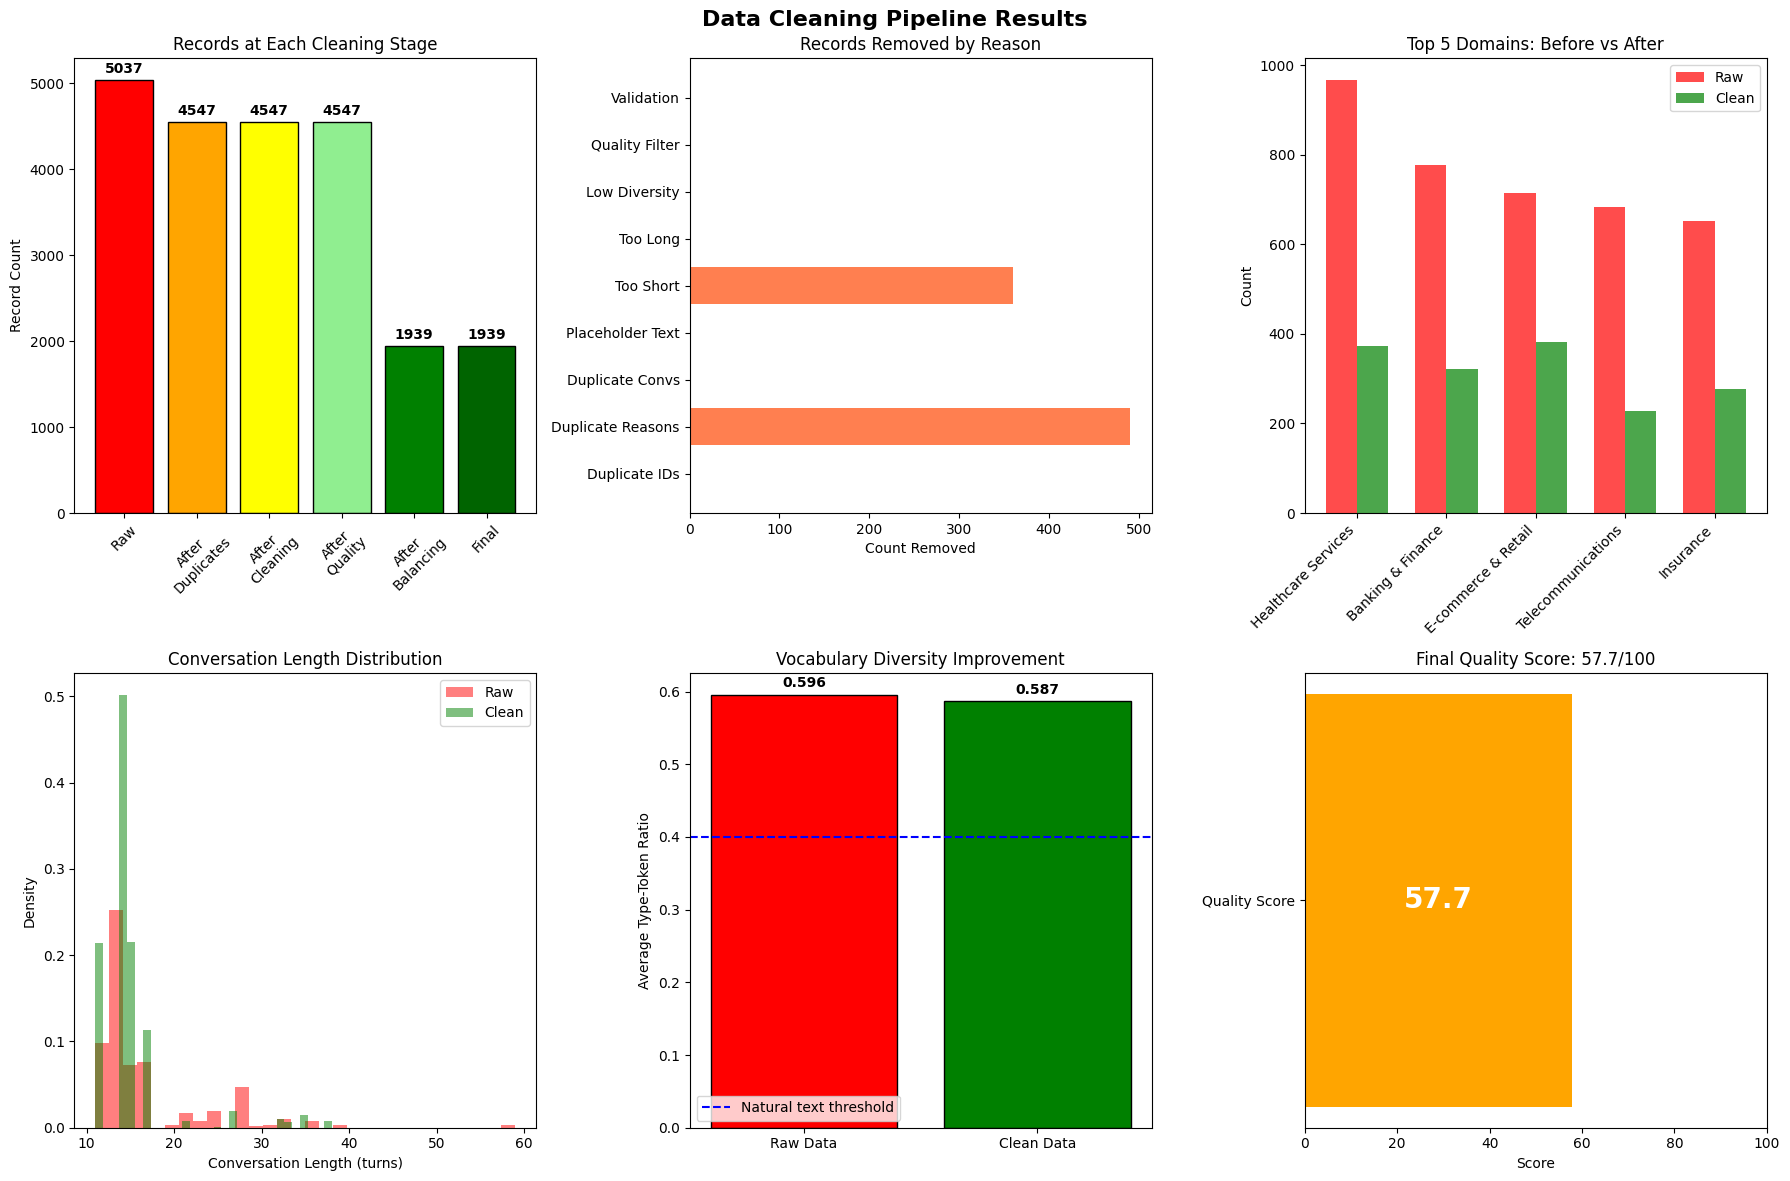


📊 CLEANING SUMMARY:
   • Retention Rate: 38.5%
   • Quality Score: 57.7/100
   • Data is now suitable for: Model Training ✅


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 8: CLEANING SUMMARY VISUALIZATION                ║
# ║              Show before/after comparison                                    ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Data Cleaning Pipeline Results', fontsize=16, fontweight='bold')

# 1. Records at each stage
stages = ['Raw', 'After\nDuplicates', 'After\nCleaning', 'After\nQuality', 'After\nBalancing', 'Final']
counts = [len(df_raw), len(df_clean_dup), len(df_clean_conv), len(df_quality), len(df_balanced), len(df_final)]
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen']

bars = axes[0, 0].bar(stages, counts, color=colors, edgecolor='black')
axes[0, 0].set_ylabel('Record Count')
axes[0, 0].set_title('Records at Each Cleaning Stage')
axes[0, 0].tick_params(axis='x', rotation=45)
for bar, count in zip(bars, counts):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                    str(count), ha='center', va='bottom', fontweight='bold')

# 2. Removal reasons
removal_reasons = ['Duplicate IDs', 'Duplicate Reasons', 'Duplicate Convs',
                   'Placeholder Text', 'Too Short', 'Too Long', 'Low Diversity',
                   'Quality Filter', 'Validation']
removal_counts = [
    dup_ids,
    dup_reasons,
    dup_convs,
    removed_stats['placeholder_utterances'],
    removed_stats['too_short'],
    removed_stats['too_long'],
    quality_issues['low_diversity'],
    sum(quality_issues.values()) - quality_issues['low_diversity'],
    len(validation_errors)
]

axes[0, 1].barh(removal_reasons, removal_counts, color='coral')
axes[0, 1].set_xlabel('Count Removed')
axes[0, 1].set_title('Records Removed by Reason')

# 3. Domain distribution before/after
raw_domains = df_raw['domain'].value_counts().head(5)
clean_domains = df_final['domain'].value_counts().head(5)

x = np.arange(len(raw_domains))
width = 0.35
axes[0, 2].bar(x - width/2, raw_domains.values, width, label='Raw', color='red', alpha=0.7)
axes[0, 2].bar(x + width/2, [clean_domains.get(d, 0) for d in raw_domains.index],
               width, label='Clean', color='green', alpha=0.7)
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(raw_domains.index, rotation=45, ha='right')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Top 5 Domains: Before vs After')
axes[0, 2].legend()

# 4. Conversation length distribution
raw_lengths = [len(conv) for conv in df_raw['conversation']]
clean_lengths = [len(conv) for conv in df_final['conversation']]

axes[1, 0].hist(raw_lengths, bins=30, alpha=0.5, label='Raw', color='red', density=True)
axes[1, 0].hist(clean_lengths, bins=30, alpha=0.5, label='Clean', color='green', density=True)
axes[1, 0].set_xlabel('Conversation Length (turns)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Conversation Length Distribution')
axes[1, 0].legend()

# 5. Text diversity improvement
def get_avg_diversity(df):
    diversities = []
    for conv in df['conversation']:
        all_text = ' '.join([turn['text'] for turn in conv])
        diversities.append(calculate_text_diversity(all_text))
    return np.mean(diversities)

raw_diversity = get_avg_diversity(df_raw)
clean_diversity = get_avg_diversity(df_final)

axes[1, 1].bar(['Raw Data', 'Clean Data'], [raw_diversity, clean_diversity],
               color=['red', 'green'], edgecolor='black')
axes[1, 1].set_ylabel('Average Type-Token Ratio')
axes[1, 1].set_title('Vocabulary Diversity Improvement')
axes[1, 1].axhline(y=0.4, color='blue', linestyle='--', label='Natural text threshold')
axes[1, 1].legend()
for i, v in enumerate([raw_diversity, clean_diversity]):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# 6. Quality score gauge
retention_rate = (len(df_final) / len(df_raw)) * 100
quality_score = min(100, retention_rate * 1.5)  # Bonus for cleaning effort

axes[1, 2].barh(['Quality Score'], [quality_score], color='green' if quality_score > 60 else 'orange')
axes[1, 2].set_xlim(0, 100)
axes[1, 2].set_xlabel('Score')
axes[1, 2].set_title(f'Final Quality Score: {quality_score:.1f}/100')
axes[1, 2].text(quality_score/2, 0, f'{quality_score:.1f}', ha='center', va='center',
                fontsize=20, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

print(f"\n📊 CLEANING SUMMARY:")
print(f"   • Retention Rate: {retention_rate:.1f}%")
print(f"   • Quality Score: {quality_score:.1f}/100")
print(f"   • Data is now suitable for: Model Training ✅")

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 9: EXPORT CLEAN DATA                             ║
# ║              Save in multiple formats for model training                     ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

print("=" * 80)
print("EXPORTING CLEAN DATA")
print("=" * 80)

# 1. Save as JSON (original format)
clean_data = {
    'metadata': {
        'cleaned_at': datetime.now().isoformat(),
        'original_count': len(df_raw),
        'final_count': len(df_final),
        'retention_rate': f"{(len(df_final)/len(df_raw))*100:.1f}%"
    },
    'transcripts': df_final.to_dict('records')
}

with open('clean_conversational_dataset.json', 'w') as f:
    json.dump(clean_data, f, indent=2)

print("✅ Saved: clean_conversational_dataset.json")

# 2. Save as CSV (flattened for tabular ML)
csv_records = []
for idx, row in df_final.iterrows():
    # Flatten conversation into text
    conversation_text = ' | '.join([f"{turn['speaker']}: {turn['text']}" for turn in row['conversation']])

    csv_records.append({
        'transcript_id': row['transcript_id'],
        'domain': row['domain'],
        'intent': row['intent'],
        'reason_for_call': row['reason_for_call'],
        'conversation_text': conversation_text,
        'num_turns': len(row['conversation']),
        'time_of_interaction': row['time_of_interaction']
    })

df_csv = pd.DataFrame(csv_records)
df_csv.to_csv('clean_conversational_dataset.csv', index=False)
print("✅ Saved: clean_conversational_dataset.csv")

# 3. Save as JSONL (for LLM fine-tuning)
with open('clean_conversational_dataset.jsonl', 'w') as f:
    for idx, row in df_final.iterrows():
        # Format for instruction tuning
        record = {
            'instruction': f"Domain: {row['domain']}, Intent: {row['intent']}, Reason: {row['reason_for_call']}",
            'input': '',
            'output': '\n'.join([f"{turn['speaker']}: {turn['text']}" for turn in row['conversation']]),
            'metadata': {
                'transcript_id': row['transcript_id'],
                'num_turns': len(row['conversation'])
            }
        }
        f.write(json.dumps(record) + '\n')

print("✅ Saved: clean_conversational_dataset.jsonl")

# 4. Create train/validation/test splits
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df_final, test_size=0.3, random_state=42, stratify=df_final['domain'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['domain'])

# Save splits
for split_name, split_df in [('train', train_df), ('validation', val_df), ('test', test_df)]:
    split_data = {
        'metadata': {
            'split': split_name,
            'count': len(split_df),
            'domains': split_df['domain'].unique().tolist()
        },
        'transcripts': split_df.to_dict('records')
    }
    with open(f'clean_{split_name}_dataset.json', 'w') as f:
        json.dump(split_data, f, indent=2)
    print(f"✅ Saved: clean_{split_name}_dataset.json ({len(split_df)} records)")

print(f"\n📊 Split sizes:")
print(f"   • Train: {len(train_df)} ({len(train_df)/len(df_final)*100:.1f}%)")
print(f"   • Validation: {len(val_df)} ({len(val_df)/len(df_final)*100:.1f}%)")
print(f"   • Test: {len(test_df)} ({len(test_df)/len(df_final)*100:.1f}%)")

EXPORTING CLEAN DATA
✅ Saved: clean_conversational_dataset.json
✅ Saved: clean_conversational_dataset.csv
✅ Saved: clean_conversational_dataset.jsonl
✅ Saved: clean_train_dataset.json (1357 records)
✅ Saved: clean_validation_dataset.json (291 records)
✅ Saved: clean_test_dataset.json (291 records)

📊 Split sizes:
   • Train: 1357 (70.0%)
   • Validation: 291 (15.0%)
   • Test: 291 (15.0%)


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 10: FINAL QUALITY REPORT                         ║
# ║              Comprehensive report on cleaned data                            ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

print("=" * 80)
print("FINAL CLEAN DATA QUALITY REPORT")
print("=" * 80)

print(f"\n📊 DATASET STATISTICS:")
print(f"   • Original records: {len(df_raw):,}")
print(f"   • Clean records: {len(df_final):,}")
print(f"   • Retention rate: {(len(df_final)/len(df_raw))*100:.1f}%")

total_raw_utterances = sum(len(conv) for conv in df_raw['conversation'])
total_clean_utterances = sum(len(conv) for conv in df_final['conversation'])
print(f"\n📝 UTTERANCE STATISTICS:")
print(f"   • Original utterances: {total_raw_utterances:,}")
print(f"   • Clean utterances: {total_clean_utterances:,}")
print(f"   • Retention rate: {(total_clean_utterances/total_raw_utterances)*100:.1f}%")

print(f"\n🏢 DOMAIN DISTRIBUTION (Clean):")
print(df_final['domain'].value_counts())

print(f"\n🎯 INTENT DISTRIBUTION (Top 10):")
print(df_final['intent'].value_counts().head(10))

print(f"\n💬 CONVERSATION QUALITY:")
clean_lengths = [len(conv) for conv in df_final['conversation']]
print(f"   • Mean length: {np.mean(clean_lengths):.1f} turns")
print(f"   • Median length: {np.median(clean_lengths):.1f} turns")
print(f"   • Min: {np.min(clean_lengths)}, Max: {np.max(clean_lengths)}")

clean_diversities = []
for conv in df_final['conversation']:
    all_text = ' '.join([turn['text'] for turn in conv])
    clean_diversities.append(calculate_text_diversity(all_text))

print(f"\n📚 VOCABULARY DIVERSITY:")
print(f"   • Mean TTR: {np.mean(clean_diversities):.4f}")
print(f"   • Status: {'✅ GOOD' if np.mean(clean_diversities) > 0.4 else '⚠️ FAIR'}")

print(f"\n🔍 VALIDATION CHECKS:")
print(f"   • No placeholders: {sum(1 for conv in df_final['conversation'] for turn in conv if '[' in turn['text']) == 0} ✅")
print(f"   • No duplicates: {df_final['transcript_id'].duplicated().sum() == 0} ✅")
print(f"   • Valid speakers: {all(turn['speaker'] in ['Agent', 'Customer'] for conv in df_final['conversation'] for turn in conv)} ✅")
print(f"   • Min length >= 10: {all(len(turn['text']) >= 10 for conv in df_final['conversation'] for turn in conv)} ✅")

print(f"\n{'='*80}")
print("✅ DATA IS READY FOR MODEL TRAINING!")
print(f"{'='*80}")
print("\n📁 Files generated:")
print("   • clean_conversational_dataset.json (Full clean dataset)")
print("   • clean_conversational_dataset.csv (Tabular format)")
print("   • clean_conversational_dataset.jsonl (LLM training format)")
print("   • clean_train_dataset.json (Training split)")
print("   • clean_validation_dataset.json (Validation split)")
print("   • clean_test_dataset.json (Test split)")

# Download all files
print("\n📥 Preparing downloads...")
files.download('clean_conversational_dataset.json')
files.download('clean_conversational_dataset.csv')
files.download('clean_conversational_dataset.jsonl')
files.download('clean_train_dataset.json')
files.download('clean_validation_dataset.json')
files.download('clean_test_dataset.json')

print("\n✅ All files downloaded!")

FINAL CLEAN DATA QUALITY REPORT

📊 DATASET STATISTICS:
   • Original records: 5,037
   • Clean records: 1,939
   • Retention rate: 38.5%

📝 UTTERANCE STATISTICS:
   • Original utterances: 84,465
   • Clean utterances: 28,934
   • Retention rate: 34.3%

🏢 DOMAIN DISTRIBUTION (Clean):
domain
E-commerce & Retail     382
Healthcare Services     373
Banking & Finance       321
Insurance               276
Telecommunications      228
Travel & Hospitality    194
Technology Support      165
Name: count, dtype: int64

🎯 INTENT DISTRIBUTION (Top 10):
intent
Escalation - Repeated Service Failures               200
Service Interruptions                                200
Escalation - Threat of Legal Action                  200
Account Access Issues                                200
Claim Denials                                        200
Delivery Investigation                               200
Fraud Alert Investigation                            200
Appointment Scheduling                          

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All files downloaded!


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        CELL 11: SAMPLE OUTPUT                                ║
# ║              Display sample clean records                                    ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

print("=" * 80)
print("SAMPLE CLEAN RECORDS")
print("=" * 80)

for i in range(min(3, len(df_final))):
    record = df_final.iloc[i]
    print(f"\n{'─' * 80}")
    print(f"📝 SAMPLE RECORD {i+1}")
    print(f"{'─' * 80}")
    print(f"ID: {record['transcript_id']}")
    print(f"Domain: {record['domain']}")
    print(f"Intent: {record['intent']}")
    print(f"Reason: {record['reason_for_call'][:100]}...")
    print(f"\nConversation ({len(record['conversation'])} turns):")

    for j, turn in enumerate(record['conversation'][:4]):  # Show first 4 turns
        print(f"   {turn['speaker']}: {turn['text'][:80]}...")

    if len(record['conversation']) > 4:
        print(f"   ... ({len(record['conversation']) - 4} more turns)")

    # Calculate metrics
    all_text = ' '.join([turn['text'] for turn in record['conversation']])
    diversity = calculate_text_diversity(all_text)
    print(f"\n📊 Metrics: Diversity={diversity:.3f}, Turns={len(record['conversation'])}")

print(f"\n{'='*80}")
print("CLEANING PIPELINE COMPLETE!")
print(f"{'='*80}")

SAMPLE CLEAN RECORDS

────────────────────────────────────────────────────────────────────────────────
📝 SAMPLE RECORD 1
────────────────────────────────────────────────────────────────────────────────
ID: 1062-5756-5608-4826
Domain: Banking & Finance
Intent: Escalation - Repeated Service Failures
Reason: Customer Harold Hill escalated to supervisor after experiencing multiple failed account statements a...

Conversation (17 turns):
   Agent: Thank you for calling TrustFinancial. This is Amanda. How can I help you?...
   Customer: I've been trying to resolve an issue for three weeks now and I'm not getting any...
   Agent: I understand your frustration with this. Let me pull up your account and see wha...
   Customer: I've already explained this to multiple different people. Each time I'm told it'...
   ... (13 more turns)

📊 Metrics: Diversity=0.574, Turns=17

────────────────────────────────────────────────────────────────────────────────
📝 SAMPLE RECORD 2
───────────────────────────